In this notebook, we are going to compare the TME method against the Euler--Maruyama method for sampling a stochastic Lorenz model. In particular, we want to show their discretisation errors and computational time.

The test model is given as follows. 

$$
\begin{aligned}
    d X_1(t) &= \sigma(X_2(t) - X_1(t)) dt + \sigma_x dW(t), \\
    d X_2(t) &= X_1(t) \, (\rho - X_3(t)) - X_2(t) dt + \sigma_y dW(t), \\
    d X_3(t) &= X_1(t)\,X_2(t) - \beta\,X_3(t) dt + \sigma_z dW(t),
\end{aligned}
$$

The model and its parameters are detailed in https://arxiv.org/pdf/2001.01328.pdf.

First, make sure you have `tme` installed ^^

In [1]:
import tme.base_jax as tme
import jax.numpy as jnp
import jax
from jax import jit, lax
from functools import partial
import matplotlib.pyplot as plt

Let us write down the SDE model as well as the discretisation method.

We are going to use a Gaussian increment type of discretisaton method:

$$
X(t_k) \approx \mathbb{E}[X(t_k) \mid X(t_{k-1})] + \xi_k,
$$

where $\xi_k \sim N(0, \mathrm{Cov}[X(t_k) \mid X(t_{k-1})])$. The Euler--Maruyama (EM) and TME methods can be seen as different means to give the conditional mean and covariance above.

The function `disc_normal()` below does this discretisation, where you need to specify how to approximate the mean and covariance in the argument `m_and_cov`. You can feed this argument by `tme_m_cov` or `em_m_cov` that corresponding to TME and EM, respectively.

In [2]:
sigma = 10.
rho = 28.
beta = 8 / 3

def drift(u):
    return jnp.array([sigma * (u[1] - u[0]), 
                     u[0] * (rho - u[2]) - u[1], 
                     u[0] * u[1] - beta * u[2]])

bb = 0.15 * jnp.eye(3)

def dispersion(_):
    return bb

def tme_m_cov(u, dt):
    return tme.mean_and_cov(x=u, dt=dt, 
                           drift=drift, dispersion=dispersion, order=3)

def em_m_cov(u, dt):
    return u + drift(u) * dt, dispersion(u) @ dispersion(u).T * dt

@partial(jit, static_argnums=(0,))
def disc_normal(m_and_cov, x0, dts, dws):    
    def scan_body(carry, elem):
        x = carry
        dt, dw = elem

        m, cov = m_and_cov(x, dt)
        chol = jnp.linalg.cholesky(cov)
        x = m + chol @ dw
        return x, x

    _, sample = lax.scan(scan_body, x0, (dts, dws))
    return sample

2022-06-07 21:16:54.548634: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:200] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 8369733632


Draw an initial value

In [3]:
key = jax.random.PRNGKey(666)

# Init cond
m0 = jnp.zeros((3, ))
P0 = jnp.eye(3)
key, subkey = jax.random.split(key)
x0 = jax.random.multivariate_normal(key=subkey, mean=m0, cov=P0)

Now we compare the discretisation errors of TME and EM. In order to do so, we need to have these two methods under a same Wiener process realisation. 

Also, we will use EM with very very small dt (here is dt=0.0001) as a reference method serving as a "ground truth solution".

In [4]:
# Very small instances
num_time_steps = 10000
T = jnp.linspace(0.0001, 1, num_time_steps)
dts = jnp.diff(T)
key, subkey = jax.random.split(key)
dws = jax.random.normal(key, shape=(dts.size, x0.shape[0]))

true_sample = disc_normal(em_m_cov, x0, dts, dws)

Okay, now we make samples from TME and EM with large dt (here is 0.01) so we can compare them how good they are.

In [5]:
# Now make samples from EM and TME with large dt
factor = 100
T_small = T[::factor]
dts_small = dts[::factor] * factor
dws_small = dws[::factor]
sample_tme = disc_normal(tme_m_cov, x0, dts_small, dws_small)
sample_em = disc_normal(em_m_cov, x0, dts_small, dws_small)

Let us compute the cummaltive absolute errors of TME and EM samples w.r.t. the ground true sample.

In [6]:
def abs_err(x1, x2):
    return jnp.sum(jnp.abs(x1 - x2), [0, 1])

abs_err_tme = abs_err(true_sample[::factor], sample_tme)
abs_err_em = abs_err(true_sample[::factor], sample_em)
print(f'Cummalative abs error of TME: {abs_err_tme}')
print(f'Cummalative abs error of EM: {abs_err_em}')

Cummalative abs error of TME: 19.80562973022461
Cummalative abs error of EM: 978.8270263671875


Looks like TME is significantly better than EM. You can try different dt and TME order by yourself.

Let's plot the samples. It looks like TME can perfectly follow the ground truth, while EM diverges a lot!

Text(0.5, 0, 't')

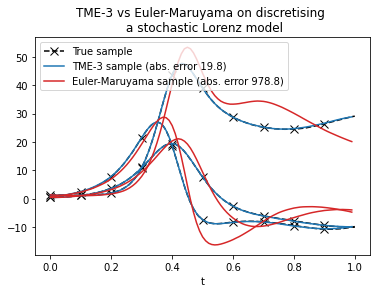

In [7]:
plt.plot(T[1:], true_sample[:, 0], c='black', linestyle='--', 
         marker='x', markevery=1000, markersize=8, label='True sample')
plt.plot(T[1:], true_sample[:, 1], c='black', 
         marker='x', markevery=1000, markersize=8, linestyle='--')
plt.plot(T[1:], true_sample[:, 2], c='black', 
         marker='x', markevery=1000, markersize=8, linestyle='--')
plt.plot(T_small, sample_tme[:, 0], c='tab:blue', label=f'TME-3 sample (abs. error {abs_err_tme:.1f})')
plt.plot(T_small, sample_tme[:, 1], c='tab:blue')
plt.plot(T_small, sample_tme[:, 2], c='tab:blue')
plt.plot(T_small, sample_em[:, 0], c='tab:red', label=f'Euler-Maruyama sample (abs. error {abs_err_em:.1f})')
plt.plot(T_small, sample_em[:, 1], c='tab:red')
plt.plot(T_small, sample_em[:, 2], c='tab:red')
plt.legend(loc='upper left')
plt.title('TME-3 vs Euler-Maruyama on discretising \n a stochastic Lorenz model')
plt.xlabel('t')

Indeed, TME can be more accurate. But how much computational efforts do we lose from using a nuke weapon like TME?

In [8]:
# Compare time
# Trigger compilation
sample_tme_2 = disc_normal(tme_m_cov, x0, dts, dws)
sample_em_2 = disc_normal(em_m_cov, x0, dts, dws)

import time
tic = time.time()
sample_tme_2 = disc_normal(tme_m_cov, x0, dts, dws)
toc = time.time()
print(toc - tic)

tic = time.time()
sample_em_2 = disc_normal(em_m_cov, x0, dts, dws)
toc = time.time()
print(toc - tic)

0.0030846595764160156
0.0007483959197998047


It looks like 0.015s is acceptable, though 0.00149 of EM is much cheaper.

We can also do a 3D plot

Text(0.5, 0, 'z')

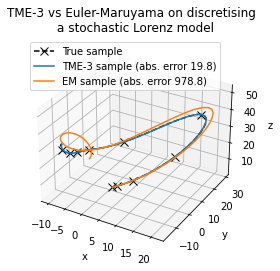

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(true_sample[:, 0], true_sample[:, 1], true_sample[:, 2], 
          c='black', linestyle='--', 
          marker='x', markevery=1000, markersize=8, label='True sample')
ax.plot3D(sample_tme[:, 0], sample_tme[:, 1], sample_tme[:, 2], 
          c='tab:blue', label=f'TME-3 sample (abs. error {abs_err_tme:.1f})')
ax.plot3D(sample_em[:, 0], sample_em[:, 1], sample_em[:, 2], 
          c='tab:orange', label=f'EM sample (abs. error {abs_err_em:.1f})')
ax.legend(loc='upper left')
ax.set_title('TME-3 vs Euler-Maruyama on discretising \n a stochastic Lorenz model')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Exercise: 

Could you try approximating $\mathbb{E}[\phi(X(t)) \mid X(0)]$ by using the `tme.expectation()` function, where $\phi$ is given as a neural network?